In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from fbprophet import Prophet

Below, we will start looking into strategies. This first strategy is taken from Ran Aroussi's blog from the link below.

https://aroussi.com/post/worlds-best-strategy


The strategy:
1. Hold GLD (SPDR Gold Trust ETF) from December 20 of every year through February 20 of the following year, and during August.
2. The rest of the time hold SPLV (Invesco S&P 500 Low Volatility ETF)

I will present two ways of backtesting the cumulative returns of the strategy:
- v1: The first version creates a cumulative sum per period, then stores increments our ret variable, which is what is ultimately returned
- v2: The second version calculates the cumulative sum only once. This graph is more similar to what is shown on Ran Aroussi's blog post.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

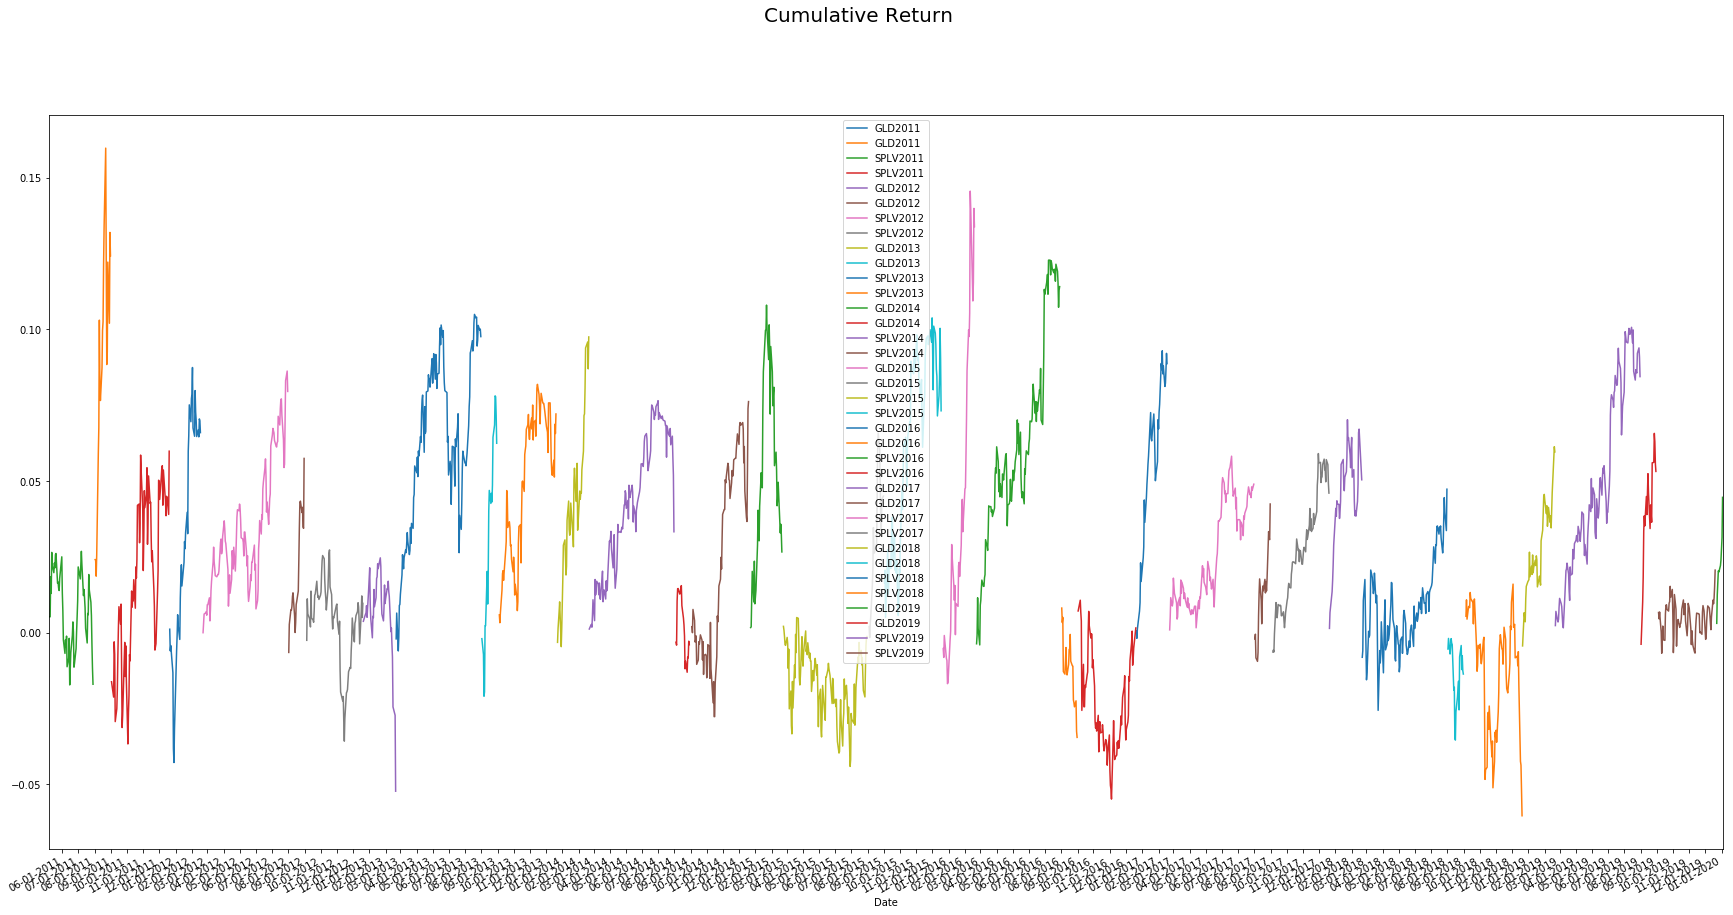

In [21]:
def worldsBestStrategyV1():
    '''
    first way of doing it; creates a cumulative sum per period, then increments the total with that sum
    '''
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    %matplotlib inline
    ret = 0
    fig, ax = plt.subplots(figsize=(30, 15))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%Y"))
    for year in range(2011, 2020):
        year = str(year)
        # Buy GLD 12/20 / Sell 2-20
        GLD_start_date,GLD_end_date = year + "-12-20", str(int(year)+1) + "-02-20"
        GLD_data = yf.download("GLD" , start = GLD_start_date , end = GLD_end_date)
        GLD_data['Daily_return']=GLD_data['Close']/GLD_data['Close'].shift(1)-1
        GLD_data["GLD" + year] = np.cumsum(GLD_data['Daily_return'])
        GLD_data["GLD" + year][1:].plot() # skip first line
        ret += GLD_data["GLD" + year][-1]
        # Buy GLD for August
        GLD_start_date,GLD_end_date = year + "-08-01", year + "-08-31"
        GLD_data = yf.download("GLD" , start = GLD_start_date , end = GLD_end_date)
        GLD_data['Daily_return']=GLD_data['Close']/GLD_data['Close'].shift(1)-1
        GLD_data["GLD" + year] = np.cumsum(GLD_data['Daily_return'])
        GLD_data["GLD" + year][1:].plot() # skip first line
        ret += GLD_data["GLD" + year][-1]
        SPLV_start_date,SPLV_end_date = year + "-02-20", year + "-07-31"
        # Buy SPLV the rest of the time
        SPLV_data = yf.download("SPLV" , start = SPLV_start_date , end = SPLV_end_date)
        SPLV_data['Daily_return']=SPLV_data['Close']/SPLV_data['Close'].shift(1)-1
        SPLV_data["SPLV" + year] = np.cumsum(SPLV_data['Daily_return'])
        SPLV_data["SPLV" + year][1:].plot() # skip first line
        ret += SPLV_data["SPLV" + year][-1]
        SPLV_start_date,SPLV_end_date = year + "-09-01", year + "-12-20"
        SPLV_data = yf.download("SPLV" , start = SPLV_start_date , end = SPLV_end_date)
        SPLV_data['Daily_return']=SPLV_data['Close']/SPLV_data['Close'].shift(1)-1
        SPLV_data["SPLV" + year] = np.cumsum(SPLV_data['Daily_return'])
        SPLV_data["SPLV" + year][1:].plot() # skip first line
        ret += SPLV_data["SPLV" + year][-1]
        
    print(" Cumulative Returns for GLD/SPLV strategy: {} ".format(ret))
    plt.legend()
    plt.suptitle('Cumulative Return', fontsize=20)

worldsBestStrategyV1()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/home/ajc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 Cumulative Returns for GLD/SPLV strategy: 1.64 


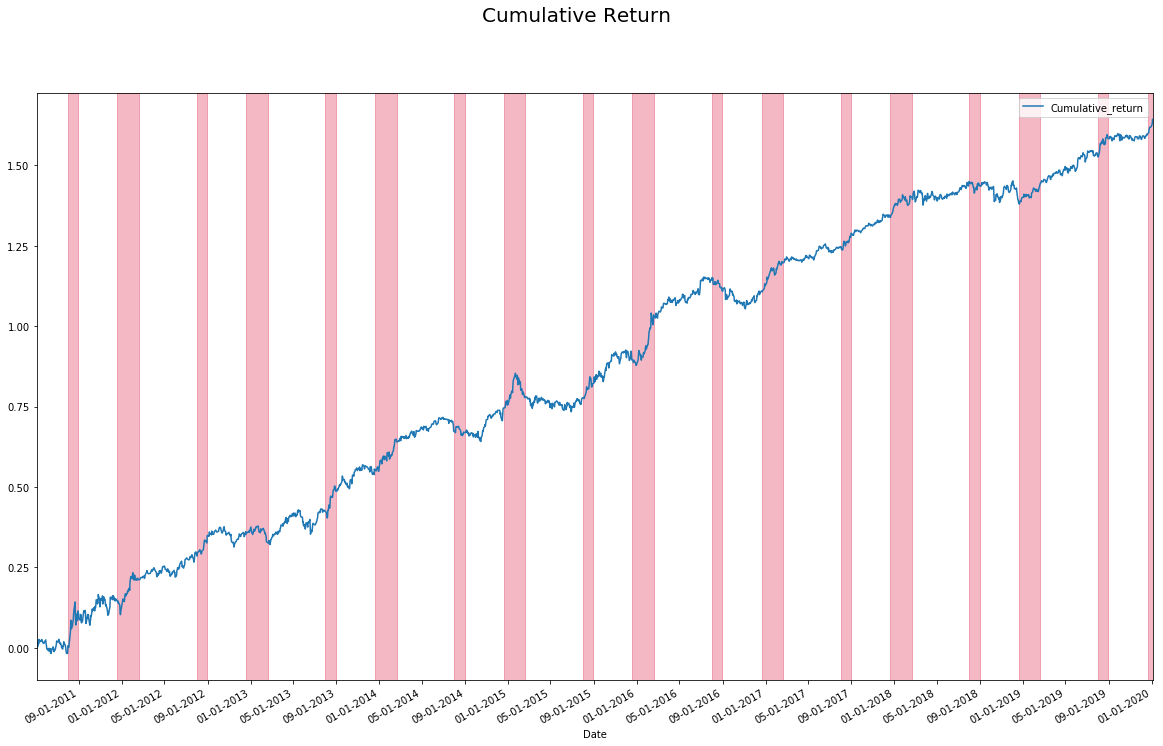

In [78]:
def worldsBestStrategyV2(ticker1: str, ticker2: str):
    '''
    second way of calculating the World's Best Strategy; creates a cumulative sum for the whole period.
    ticker 1: returns are shaded in red
    ticker 2: returns are shaded in white
    ''' 
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    %matplotlib inline
    ticker1, ticker2 = 'GLD', "SPLV"
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%Y"))
    base_df = pd.DataFrame()
    hold_periods = []
    for year in range(2011, 2020):
        year = str(year)
        # Buy GLD 12/20 / Sell 2-20
        ticker1_start_date, ticker1_end_date = year + "-12-20", str(int(year)+1) + "-02-19"
        hold_periods.append((ticker1_start_date, ticker1_end_date))
        df1 = yf.download(ticker1 , start = ticker1_start_date , end = ticker1_end_date)
        df1['Daily_return']=df1['Close']/df1['Close'].shift(1)-1

        ticker2_start_date, ticker2_end_date = year + "-02-20", year + "-07-31"
        df3 = yf.download(ticker2 , start = ticker2_start_date , end = ticker2_end_date)
        df3['Daily_return']=df3['Close']/df3['Close'].shift(1)-1

        ticker1_start_date, ticker1_end_date  = year + "-08-01", year + "-08-31"
        hold_periods.append((ticker1_start_date, ticker1_end_date ))
        df2 = yf.download(ticker1 , start = ticker1_start_date , end = ticker1_end_date)
        df2['Daily_return']=df2['Close']/df2['Close'].shift(1)-1


        ticker2_start_date, ticker2_end_date = year + "-09-01", year + "-12-19"
        df4 = yf.download(ticker2 , start = ticker2_start_date , end = ticker2_end_date)
        df4['Daily_return'] = df4['Close'] / df4['Close'].shift(1)-1
        base_df = pd.concat([base_df,df1, df3, df2, df4])

    for i,j in enumerate(base_df['Daily_return']):
        if  pd.isna(base_df['Daily_return'][i]) :
            base_df['Daily_return'][i] = 0

    base_df 
    base_df['Cumulative_return'] = np.cumsum(base_df['Daily_return'])
    base_df['Cumulative_return'].plot()
    for tup in hold_periods:
        ax.axvspan(pd.to_datetime(tup[0]), pd.to_datetime(tup[1]),  color="crimson", alpha=0.3)
    returns = base_df['Cumulative_return'][-1]
    print(" Cumulative Returns for {}/{} strategy: {:.2f} ".format(str(ticker1), str(ticker2), returns))
    plt.legend()
    plt.suptitle('Cumulative Return', fontsize=20)
worldsBestStrategyV2("GLD", "SPLV")

The red area indicates the time period in which GLD is invested in. Compared to investing in SPY/SPLV (see below), we see that the GLD/SPLV strategy yields ~60% more returns over the 8 year period.

[*********************100%***********************]  1 of 1 completed
 Cumulative Returns for SPY strategy: 1.0224494096561476 
[*********************100%***********************]  1 of 1 completed
 Cumulative Returns for VTSAX strategy: 1.0123040663634182 


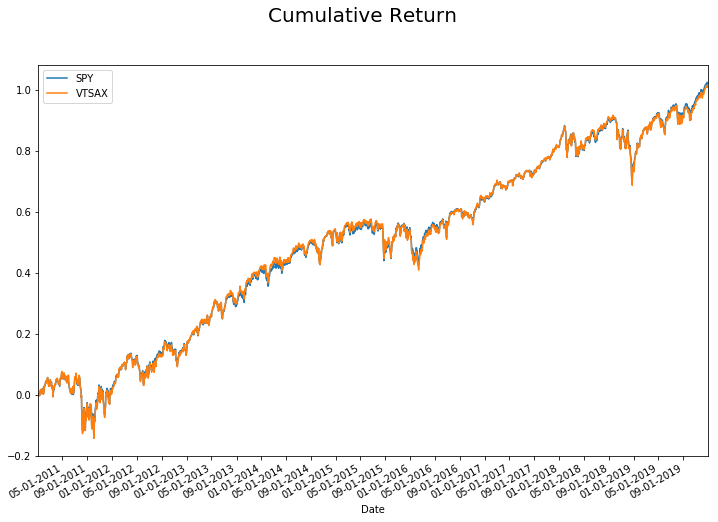

In [48]:
def cumulative_return_adjusted(start_year: int, end_year:int, tickers_str:[str]):
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%Y"))
    start_year, end_year = str(start_year), str(end_year)
    for ticker in tickers_str:
        start_date,end_date = start_year + "-01-01", end_year + "-12-31"
        data = yf.download(ticker , start = start_date , end = end_date)
        data['Daily_return']=data['Close']/data['Close'].shift(1)-1
        # Cumulative Returns
        data[ticker] = np.cumsum(data['Daily_return'])
        data[ticker][1:].plot() # skip first line\
        print(" Cumulative Returns for {} strategy: {} ".format(ticker,data[ticker][-1]))
    plt.legend()
    plt.suptitle('Cumulative Return', fontsize = 20)

cumulative_return_adjusted(2011,2019,["SPY", "VTSAX"])

Now we will dig into <b><i>why</i></b> this works using Facebook's Prophet API to analyze the 10-year historical seasonality. 

[*********************100%***********************]  1 of 1 completed


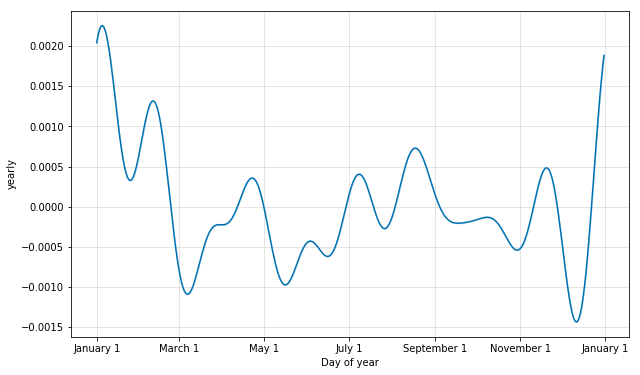

In [5]:
def yearly_seasonality_graph(tickers_str: [str], start_date: str, end_date: str):
    '''
    Given a list of tickers, a start date, and an end date, it calculates the yearly seasonality for the returns 
    of that ticker. It is recommended that you feed in at least 10 years of data to capture yearly seasonality. 
    '''
    from fbprophet.plot import plot_yearly
    %matplotlib inline
    for ticker in tickers_str:
        # Pull data from Yahoo Finance 
        data = yf.download(ticker , start = start_date , end = end_date)
        
        # Create percentage daily returns column 
        data['Daily_return'] = data['Adj Close']/data['Adj Close'].shift(1)-1
        
        # Rename our x and y variables to fit FB Prophet. 
        df = data.reset_index().rename(columns={'Date':'ds', 'Daily_return':'y'})
        
        # FB Prophet 
        m = Prophet(daily_seasonality=False).fit(df)
        a = plot_yearly(m)

yearly_seasonality_graph(["GLD"], '2000-12-31', '2019-12-31')

We can see that on average in the past 20 years, there are positive returns between December-January and August for GLD. 

In [28]:
''' Custom function to retrieve the seasonality data frame. '''

def seasonality_df(m, yearly_start=0,  name='yearly'):
    from fbprophet.plot import seasonality_plot_df
    """Plot the yearly component of the forecast.
    Parameters
    ----------
    m: Prophet model.
    ax: Optional matplotlib Axes to plot on. One will be created if
        this is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    yearly_start: Optional int specifying the start day of the yearly
        seasonality plot. 0 (default) starts the year on Jan 1. 1 shifts
        by 1 day to Jan 2, and so on.
    figsize: Optional tuple width, height in inches.
    name: Name of seasonality component if previously changed from default 'yearly'.
    Returns
    -------
    a dataframe
    """
    # Compute yearly seasonality for a Jan 1 - Dec 31 sequence of dates.
    days = (pd.date_range(start='2017-01-01', periods=365) +
            pd.Timedelta(days=yearly_start))
    df_y = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_y)
    return seas


In [29]:
tickers_str, start_date, end_date = ["GLD"], '2000-12-31', '2019-12-31'
import matplotlib as plt
%matplotlib inline
for ticker in tickers_str:
    # Pull data from Yahoo Finance 
    data = yf.download(ticker , start = start_date , end = end_date)

    # Create percentage daily returns column 
    data['Daily_return'] = data['Adj Close']/data['Adj Close'].shift(1)-1

    # Rename our x and y variables to fit FB Prophet. 
    df = data.reset_index().rename(columns={'Date':'ds', 'Daily_return':'y'})

    # FB Prophet 
    m = Prophet(daily_seasonality=False).fit(df)
    seas_df = seasonality_df(m)



[*********************100%***********************]  1 of 1 completed


In [30]:
seas_df.head()

,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper
0,0.005347,0.005347,0.005347,0.003304,0.003304,0.003304,0.002043,0.002043,0.002043,0.0,0.0,0.0
1,0.000249,0.000249,0.000249,-0.001890,-0.001890,-0.001890,0.002139,0.002139,0.002139,0.0,0.0,0.0
2,0.000572,0.000572,0.000572,-0.001635,-0.001635,-0.001635,0.002207,0.002207,0.002207,0.0,0.0,0.0
3,0.001141,0.001141,0.001141,-0.001106,-0.001106,-0.001106,0.002247,0.002247,0.002247,0.0,0.0,0.0
4,0.000618,0.000618,0.000618,-0.001640,-0.001640,-0.001640,0.002258,0.002258,0.002258,0.0,0.0,0.0


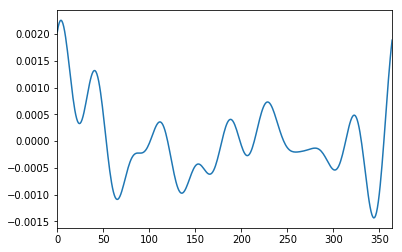

In [31]:
seas_df['yearly'].plot()

2013
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2014
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2015
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2016
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2017
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2018
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2019
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

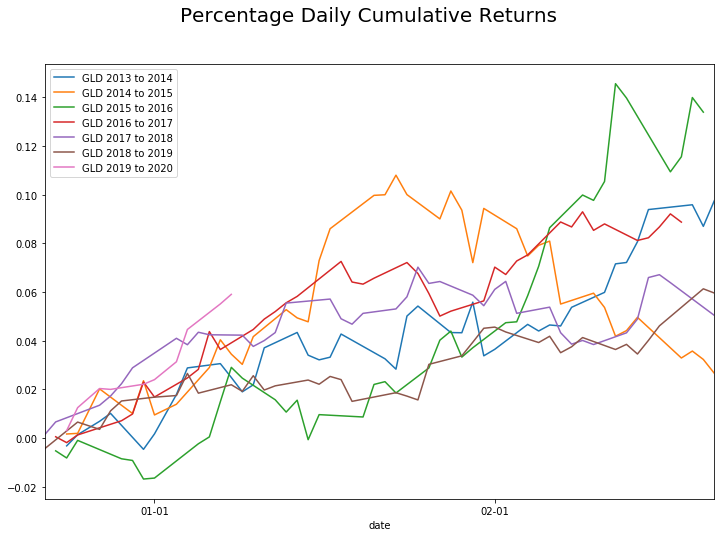

In [131]:
def normalize_date(date, over_new_years = True):
    day_of_year = date.timetuple().tm_yday
    if over_new_years and day_of_year >300:
        normalized_date =  datetime.date(2018,1,1) + datetime.timedelta(day_of_year)
    elif over_new_years:
        normalized_date =  datetime.date(2019,1,1) + datetime.timedelta(day_of_year)
    else:
        normalized_date =  datetime.date(2018,1,1) + datetime.timedelta(day_of_year)
    return normalized_date

def cross_sectional_seasonality_graph(st_date:str, en_date: str,  tickers:str):
    '''   
    '''
    import datetime
    today = datetime.datetime.now()
    day_of_year = (today - datetime.datetime(today.year, 1, 1)).days + 1
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.xaxis.set_major_locator( mdates.MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
    
    # If the date range goes over the new years, we need to handle the data a certain way. 
    if int(st_date[:2]) > int(en_date[:2]):
        for year in range(2013,2020):

            year = str(year)
            print(year)
            
            # Pull stocks from Yahoo Finance
            start_date = year + '-' + st_date 
            end_date =  year + '-12-31' 
            df1 = yf.download(ticker , start = start_date , end = end_date)
            new_key = ticker + " " + year + " to " + str(int(year) + 1)
            year = str(int(year) + 1)
            start_date = year  + '-01-01'""
            end_date =  year + '-' + en_date 
            df2 = yf.download(ticker , start = start_date , end = end_date)
            
            # Aggregate dataframe
            data = pd.concat([df1,df2])
            data.sort_index(inplace=True)
            data['Daily_return']=data['Close']/data['Close'].shift(1)-1
            
            # Calculate umulative Returns
            data[new_key] = np.cumsum(data['Daily_return'])

            # Normalize dates
            data['date'] = data.index
            data['date'] = data.apply(lambda x: normalize_date(x['date'], True), axis = 1 )
            data.set_index('date', inplace = True)
            
            # Plot
            data[new_key][1:].plot() # skip first line
            
    else:
        # Else, process regular date range
        for year in range(2013,2019):
            year = str(year)
            print(year)
            
            # Pull stocks
            start_date = year + '-' + st_date 
            end_date =  year + '-' + en_date 
            data = yf.download(ticker , start = start_date , end = end_date)
            data['Daily_return']=data['Close']/data['Close'].shift(1)-1
            data.sort_index(inplace=True)
            
            # Cumulative Returns
            new_key = ticker + " " + year

            data[new_key] = np.cumsum(data['Daily_return'])

            # Normalize dates
            data['date'] = data.index
            data['date'] = data.apply(lambda x: normalize_date(x['date'], False), axis = 1 )
            data.set_index('date', inplace = True)

            # Plot
            data[new_key][1:].plot() # skip first line

    plt.legend()
    plt.suptitle('Percentage Daily Cumulative Returns', fontsize=20)
    
cross_sectional_seasonality_graph('12-20', '02-20', "GLD")